In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import glob
import os
import re
import pandas as pd

###################################################

from scipy.interpolate import interp1d
from scipy.integrate import quad, simps
from astropy.table import Table, vstack
import string

def get_digits(name):
    translator = string.maketrans('', '')
    digit_trans = translator.translate(translator, string.digits)
    digits = name.translate(translator, digit_trans)
    return digits


def blueshift(spectrum, z):
    spectrum[:, 0] /= (1 + z)
    return spectrum


def get_maxfluxHa(spectrum):
    Hamask = (spectrum[:, 0] > 6540) & (spectrum[:, 0] < 6580)
    fluxHa = spectrum[Hamask]
    maxfluxHa = np.sum(fluxHa[:, 1])
    return maxfluxHa


def resample(spectrum, Lmin, Lmax, dL):
    assert Lmin >= spectrum[:, 0].min(), "Lmin must be >= than min spectral wavelength"
    assert Lmax <= spectrum[:, 0].max(), "Lmax must be <= than max spectral wavelength"
    
    spline = interp1d(spectrum[:, 0], spectrum[:, 1])
    
    x = np.arange(Lmin, Lmax, dL)
    integrated_spec = spline(x)
    
    out_spectrum = np.array([np.arange(Lmin + dL/2, Lmax + dL/2, dL), integrated_spec]).T
    assert out_spectrum.shape == ((Lmax - Lmin)/dL, 2)
    del spectrum
    
    return out_spectrum

In [3]:
flist_deep = glob.glob("2017-02-10_euclid_sims_deep/*")
flist_wide = glob.glob("2017-02-10_euclid_sims_wide/*")
flist_clean = glob.glob("/Users/brunomor/Work/Dedale/data/euclid_simulations/" +
                        "2017-02-10_euclid_dedale_meeting_run/2017-02-10_euclid_run_individual_spectra_for_TIPS/" +
                        "clean*fits")
flist_deep.sort()
flist_wide.sort()
flist_clean.sort()
print(len(flist_deep), len(flist_wide), len(flist_clean))

10010 10021 10194


In [4]:
flist_deep = flist_deep[:-10]
flist_wide = flist_wide[:-21]
flist_clean = flist_clean[:-194]

In [5]:
for i, (wide, deep, clean) in enumerate(zip(flist_wide, flist_deep, flist_clean)):
    assert os.path.basename(wide) == os.path.basename(deep), "List ordering is wrong"

In [37]:
%%time
count = 0
outwide = Table()
outdeep = Table()

for i, (wname, dname) in enumerate(zip(flist_wide[9000:], flist_deep[9000:])):
    spec_id = re.findall("\d+", wname)[-1]
    wide = fits.getdata(wname)
    deep = fits.getdata(dname)
    
    if i == 0:
        outwide["lambda"] = wide.field("wave")
        outdeep["lambda"] = deep.field("wave")

    if np.all(np.isnan(wide.field("flux"))) or np.all(np.isnan(deep.field("flux"))):
        continue
    
    outwide[spec_id] = wide.field("flux")
    outdeep[spec_id] = deep.field("flux")
    count += 1
    if i%100 == 0:
        print(i, end=",")
print(count)

0,100,200,300,400,500,600,700,800,900,928
CPU times: user 39.2 s, sys: 2.73 s, total: 42 s
Wall time: 1min


In [39]:
outdeep.write('/Users/brunomor/Work/Dedale/data/euclid_simulations/2017-02-10_euclid_dedale_meeting_run/2017-02-10_TIPS_results/2017-02-13_euclid_deep_spectra_09.csv')
outwide.write('/Users/brunomor/Work/Dedale/data/euclid_simulations/2017-02-10_euclid_dedale_meeting_run/2017-02-10_TIPS_results/2017-02-13_euclid_wide_spectra_09.csv')

In [66]:
deep2 = glob.glob("2017-02-13_euclid_wide_spectra_0*.csv")
deep2.sort()
import time
ed_out = [pd.read_csv(deep2[0])]
for fname in deep2[1:]:
    t0 = time.time()
    edeep = pd.read_csv(fname)
    del edeep["lambda"]
    ed_out.append(edeep)
    print(time.time() - t0)
%time outdata = pd.concat(ed_out, axis=1)
outdata.to_csv("2017-02-13_euclid_wide_spectra_merged.csv", index=False)

0.174654006958
0.178313970566
0.190670967102
0.184109926224
0.184491872787
0.172743082047
0.177975893021
0.16900396347
0.179556846619
CPU times: user 11.1 ms, sys: 8.59 ms, total: 19.7 ms
Wall time: 19.6 ms


In [5]:
%time indeep = Table.read("2017-02-13_euclid_sims_postprocessing/2017-02-13_euclid_deep_spectra_merged.csv")
%time inwide = Table.read("2017-02-13_euclid_sims_postprocessing/2017-02-13_euclid_wide_spectra_merged.csv")

CPU times: user 3.84 s, sys: 288 ms, total: 4.12 s
Wall time: 4.14 s
CPU times: user 3.93 s, sys: 262 ms, total: 4.19 s
Wall time: 4.21 s


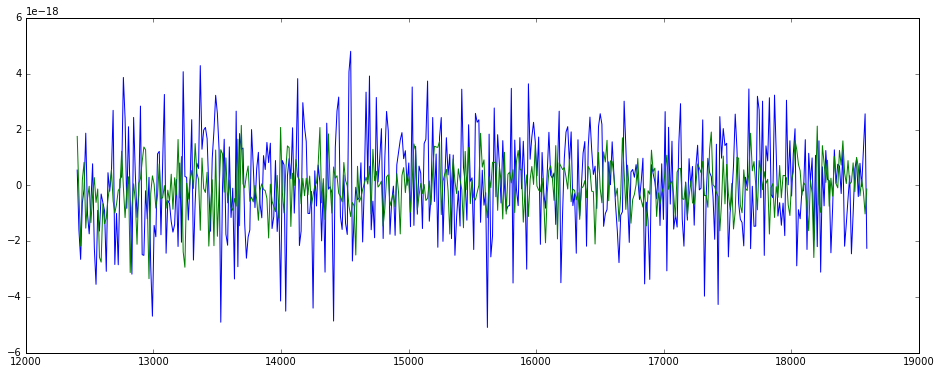

In [27]:
plt.figure(figsize=(16, 6))
plt.plot(inwide["lambda"], inwide['1000227'], "b")
plt.plot(indeep["lambda"], indeep['1000227'], "g")

# 3) Resampling Clean spectra to correspond to noisy versions

In [95]:
specids = inwide.colnames
specids.remove('lambda')
outclean = Table()
Lmin = 10000
Lmax = 20000
dL = 2
wavelengths = np.arange(Lmin + dL/2, Lmax + dL/2, dL)
outclean["lambda"] = wavelengths

for i, fname in enumerate(flist_clean):
    spec_id = re.findall("\d+", fname)[-1]
    if spec_id not in specids:
        continue
    clean = Table.read(fname)
    spectrum = np.array([clean["wave"], clean["flux"]]).T            
    spectrum = resample(spectrum, Lmin, Lmax, dL)
    outclean[spec_id] = spectrum[:, 1]
    print(i, end=',')

0,2,3,4,5,6,7,8,9,10,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,79,80,81,82,83,84,86,87,88,89,90,91,92,93,95,96,98,99,100,101,102,103,104,105,106,107,108,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,127,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,145,147,149,150,151,152,153,154,155,156,158,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,184,185,186,187,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,281,282,283,284,285,286,287,288,289,290,291,292,296,297,299,300,301,

In [98]:
pdclean = outclean.to_pandas()

In [99]:
%time pdclean.to_csv("2017-02-13_euclid_clean_spectra_merged.csv", index=False)

CPU times: user 1min 47s, sys: 2.17 s, total: 1min 49s
Wall time: 1min 50s


# Comparisons Wide vs Deep

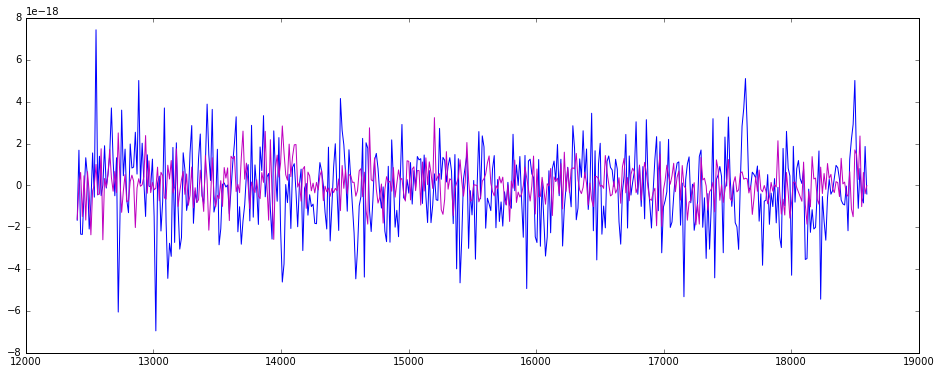

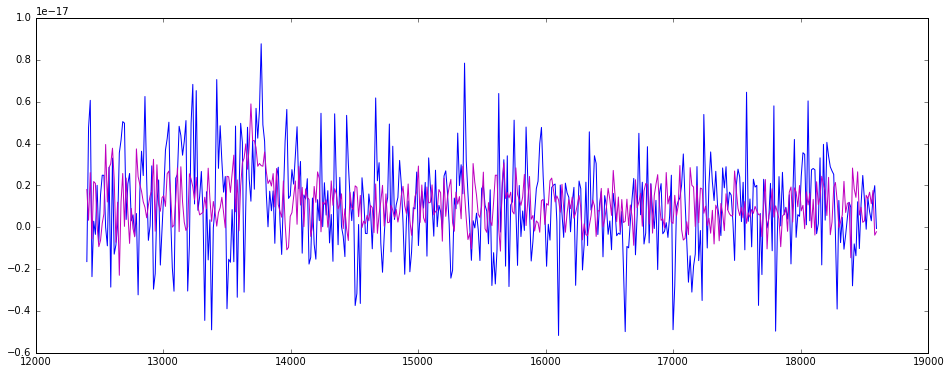

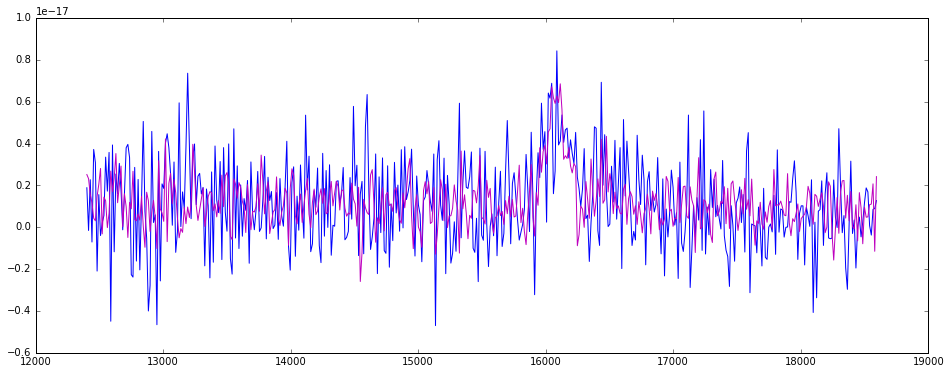

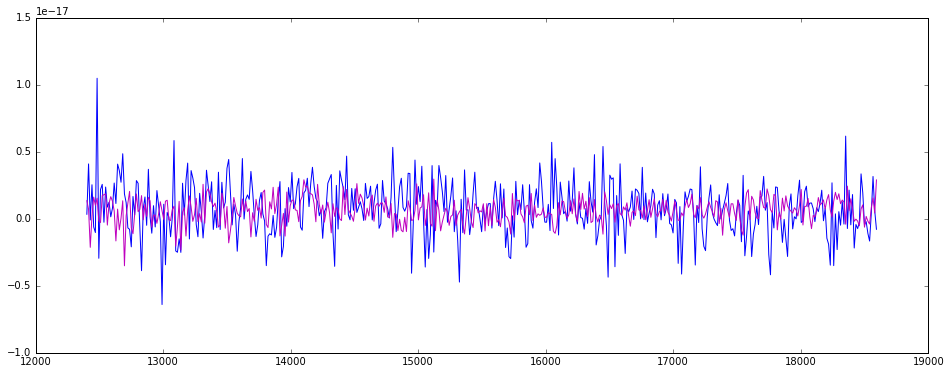

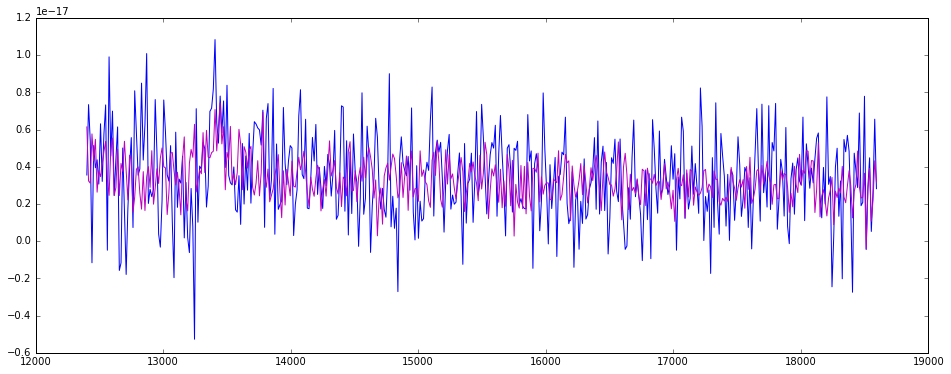

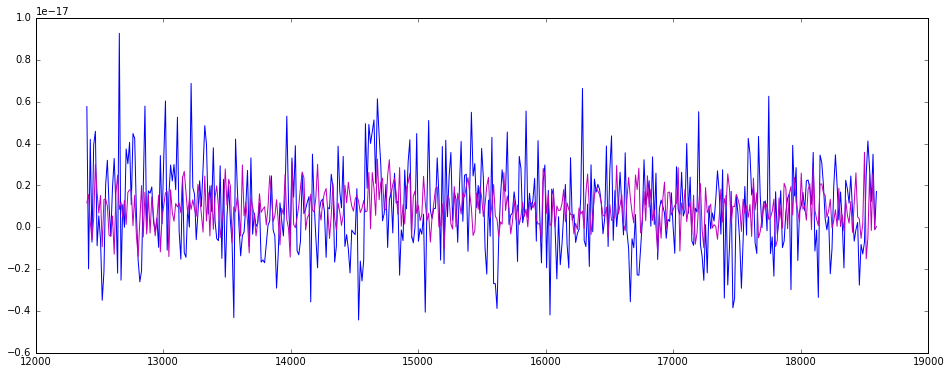

In [28]:
count = 0
for ids in inwide.colnames[1:]:
    if inwide[ids].max() < 7e-18:
        continue
    count += 1
    plt.figure(figsize=(16, 6))
    plt.plot(inwide["lambda"], inwide[ids], "b")
    plt.plot(indeep["lambda"], indeep[ids], "m")
    #plt.plot(outclean["lambda"], outclean[ids], "y")
    if count > 5:
        break

In [110]:
np.all(np.array(outclean.colnames) == np.array(inwide.colnames))

True

In [11]:
ls

2016-06-22_cosmossnap_photometry.out
2017-02-10_euclid_sims_deep/
2017-02-10_euclid_sims_wide/
2017-02-13_euclid_sims_postprocessing/
2017-02-13_euclid_simulations_postprocessing.ipynb
2017-02-13_photometry_euclid_realistic_noise_run.csv
2017-02-14_euclid_noise_sim_tests/
2017-02-15_euclid_temp_noise_for_Joana/
mpdr_conf_spe.fits
subprocess_try.py


# Eyeballing the Euclid Deep

In [19]:
edeep = pd.read_csv("2017-02-13_euclid_sims_postprocessing/2017-02-13_euclid_deep_spectra_merged.csv")

In [17]:
for colname in edeep.columns.values:
    print(colname, end=",")

lambda,1000227,1000653,1000656,1000700,1000718,1000876,1000973,1001208,1001237,1001267,1001488,1001732,1001796,1002206,1002278,1002645,1002674,1002706,1002813,1002863,1003442,1003475,1003733,1003742,1003827,1003829,1004019,1004078,1004373,1004385,1004490,1004500,1004784,1004818,1004870,1004974,1005013,1005053,1005083,1005131,1005214,1005277,1005327,1005333,1005337,1005444,1005446,1005800,1005859,1006044,1006196,1006433,1006444,1006534,1006579,1006583,1006711,1006717,1006730,1006764,1006765,1006833,1006978,1006984,1007045,1007108,1007329,1007459,1007467,1007604,1007822,1007840,1007863,1008111,1008122,1008123,1008136,1008183,1008301,1008941,1009002,1009108,1009190,1009817,1009903,1010323,1010432,1011212,1011755,1011782,1011788,1011990,1012168,1012211,1012213,1012216,1012692,1012727,1012745,1012824,1013000,1013122,1013163,1013168,1013169,1013253,1013268,1013269,1013519,1013547,1013595,1013695,1013714,1013733,1013741,1014207,1014460,1014679,1014699,1014857,1015042,1015500,1015885,1015959,1

0,1,2,3,4,5,6,

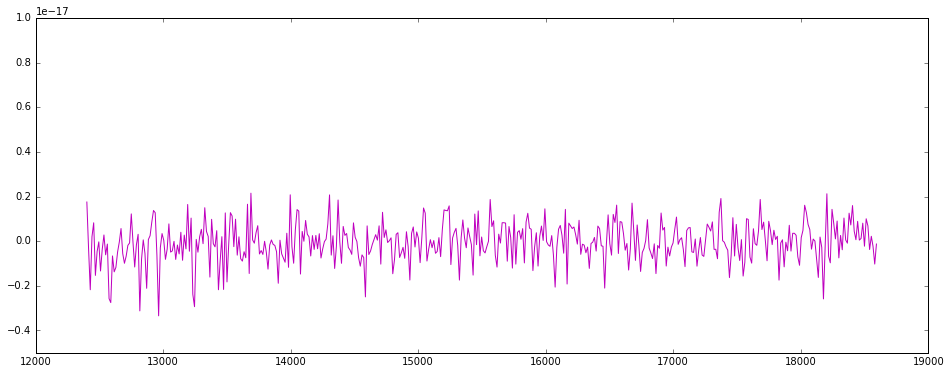

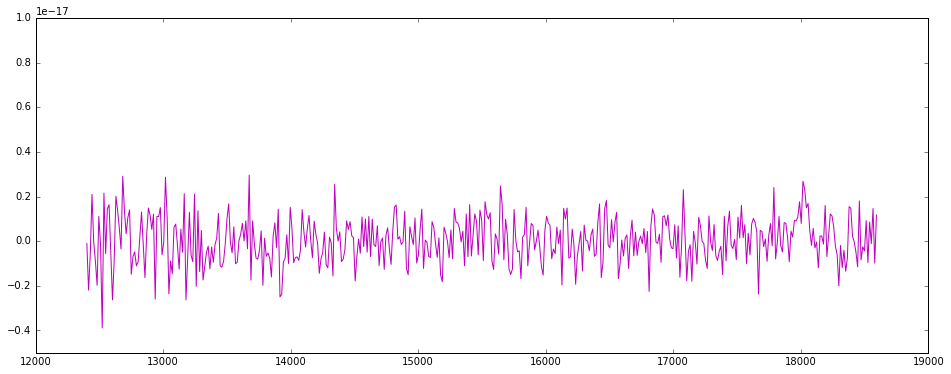

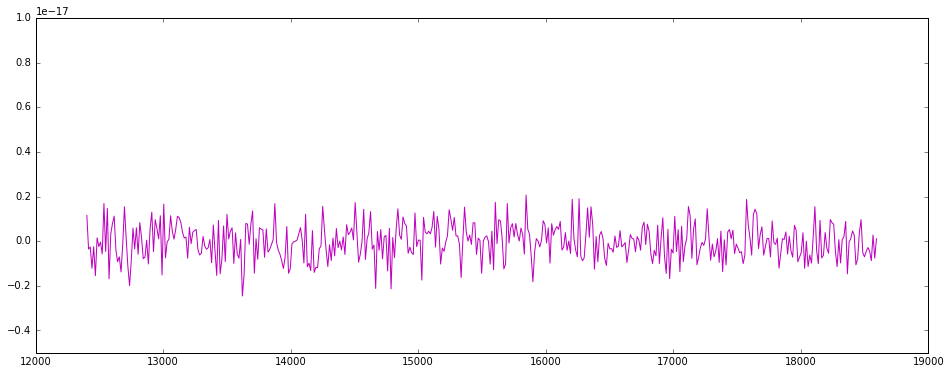

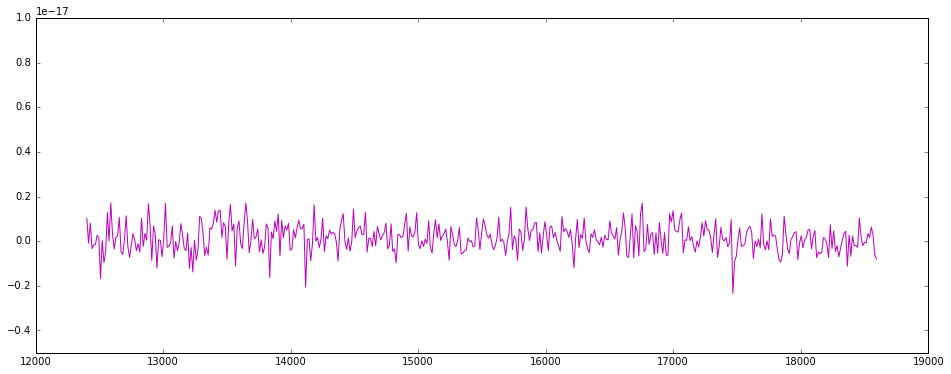

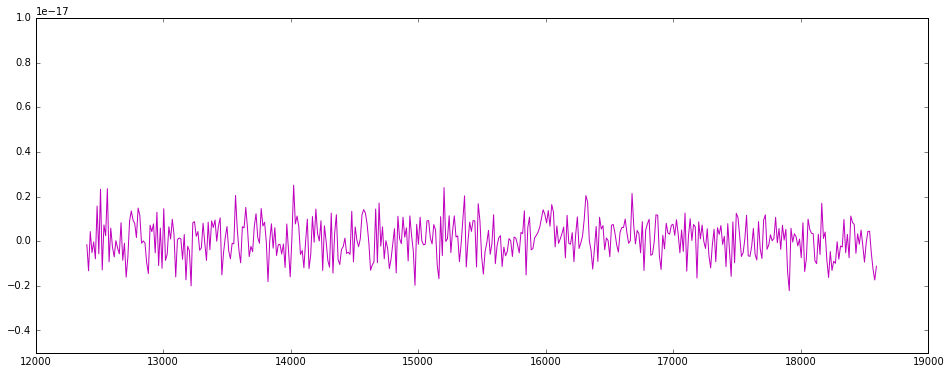

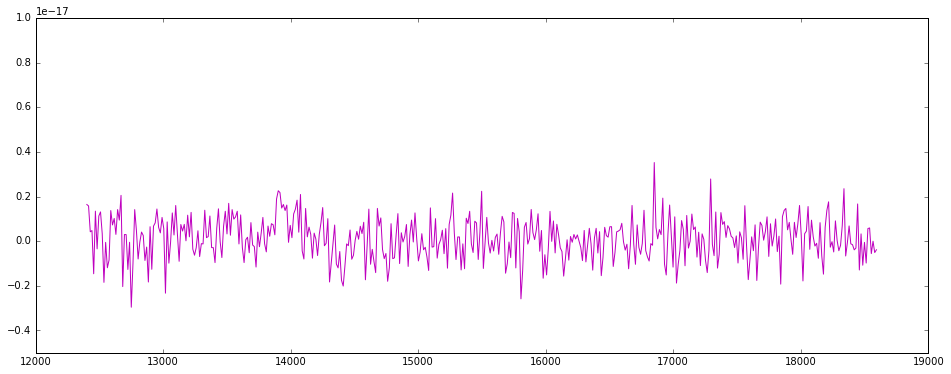

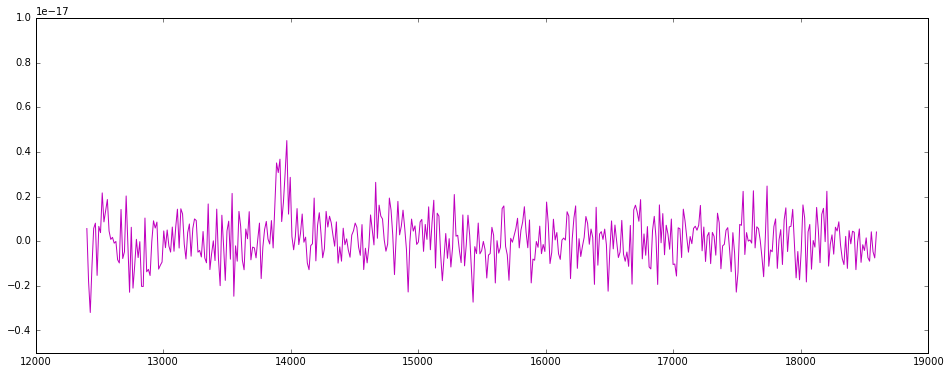

In [21]:
specs = edeep.columns.values[1:]
means = []
for i, specname in enumerate(specs):
    plt.figure(figsize=(16, 6))
    plt.plot(edeep["lambda"], edeep[specname], "m")
    plt.ylim(-5e-18, 1.0e-17)
    print(i, end=",")
    if i > 5:
        break

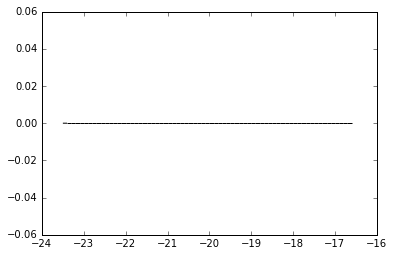

In [22]:
_ = plt.hist(np.log10(np.absolute(means)), bins=np.arange(-23.5, -16.5, 0.1))

In [25]:
temp_clean = pd.read_csv("/Users/brunomor/Work/Dedale/data/euclid_simulations/2016-09-23_templates_euclid_run_with_noise/templates_clean.csv")
print(temp_clean["lambda"].min(), temp_clean["lambda"].max())
del temp_clean

temp_high = pd.read_csv("/Users/brunomor/Work/Dedale/data/euclid_simulations/2016-09-23_templates_euclid_run_with_noise/templates_highsnr.csv")
print(temp_high["lambda"].min(), temp_high["lambda"].max())
del temp_high

1252.5 19997.5
1252.5 19997.5


In [24]:
c[signal>0] = stats.poisson.rvs(signal[signal>0]+(dc*et))

(1252.5, 19997.5)

In [30]:
from scipy import stats
help(stats.poisson.rvs)

Help on method rvs in module scipy.stats._distn_infrastructure:

rvs(self, *args, **kwargs) method of scipy.stats._discrete_distns.poisson_gen instance
    Random variates of given type.
    
    Parameters
    ----------
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information).
    loc : array_like, optional
        Location parameter (default=0).
    size : int or tuple of ints, optional
        Defining number of random variates (Default is 1).  Note that `size`
        has to be given as keyword, not as positional argument.
    random_state : None or int or ``np.random.RandomState`` instance, optional
        If int or RandomState, use it for drawing the random variates.
        If None, rely on ``self.random_state``.
        Default is None.
    
    Returns
    -------
    rvs : ndarray or scalar
        Random variates of given `size`.



In [32]:
stats.poisson.rvs(2*np.ones(10))

array([3, 1, 3, 1, 2, 2, 0, 2, 1, 4])

# Postprocessing TIPS noise

In [3]:
%%time

flist_deep = glob.glob("working_directory_flat_deep/OUTPUT/*")
flist_wide = glob.glob("working_directory_flat_wide/OUTPUT/*")

flist_deep.sort()
flist_wide.sort()

count = 0
outwide = Table()
outdeep = Table()

for i, (wname, dname) in enumerate(zip(flist_wide, flist_deep)):
    wide = fits.getdata(wname)
    deep = fits.getdata(dname)
    
    if i == 0:
        outwide["lambda"] = wide.field("wave")
        outdeep["lambda"] = deep.field("wave")

    if np.all(np.isnan(wide.field("flux"))) or np.all(np.isnan(deep.field("flux"))):
        print("%d is empty, skipping..." % i)
        continue
    
    outwide["noise" + str(i)] = wide.field("flux")
    outdeep["noise" + str(i)] = deep.field("flux")
    count += 1
    if i%100 == 0:
        print(i, end=",")
print(count)

0,100,200,300,400,500,600,700,800,900,1000
CPU times: user 42.4 s, sys: 2.44 s, total: 44.9 s
Wall time: 1min 3s


(-4e-18, 4e-18)

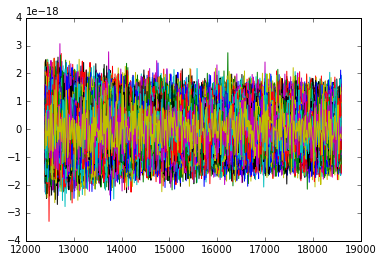

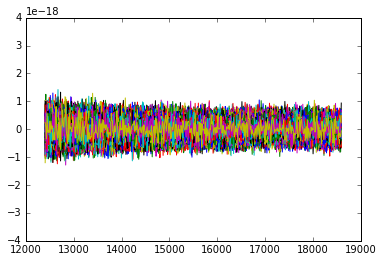

In [10]:
for flux in outwide.colnames[1:]:
    plt.plot(outwide["lambda"], outwide[flux])

plt.figure()
for flux in outdeep.colnames[1:]:
    plt.plot(outdeep["lambda"], outdeep[flux])
plt.ylim(-4e-18, 4e-18)

In [11]:
outdeep.write('/Users/brunomor/Work/Dedale/data/euclid_simulations/2017-02-10_euclid_dedale_meeting_run/2017-02-10_TIPS_results/2017-03-02_euclid_deep_noise.csv')
outwide.write('/Users/brunomor/Work/Dedale/data/euclid_simulations/2017-02-10_euclid_dedale_meeting_run/2017-02-10_TIPS_results/2017-03-02_euclid_wide_noise.csv')